In [1]:
import time
import datetime
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import pybullet as p
import pybullet_data

import torch
from torch_cluster import radius_graph, radius
from torch_scatter import scatter

import matplotlib
import matplotlib.pyplot as plt

import edf
from edf.pybullet_env.utils import get_image, axiscreator, img_data_to_pointcloud
from edf.visual_utils import plot_color_and_depth, scatter_plot, scatter_plot_ax, visualize_samples, visualize_sample_cluster
from edf.pybullet_env.env import MugTask

device = 'cuda'
gpu_idx = 0
torch.cuda.set_device(gpu_idx)

pybullet build time: Dec  1 2021 18:34:28


In [2]:
import gzip
import pickle

folder_name = 'demo'
task_name = 'mug_task'
path = f'{folder_name}/{task_name}'

with gzip.open(path + f'/upright.gzip','rb') as f:
    upright_samples = pickle.load(f)

with gzip.open(path + f'/lying.gzip','rb') as f:
    lying_samples = pickle.load(f)

# Load Models

In [3]:
from torch import nn
from pytorch3d import transforms

import e3nn.nn
from e3nn import o3
from e3nn.math import soft_one_hot_linspace, soft_unit_step

from edf.utils import preprocess
from edf.models import SE3Transformer, SE3TransformerLight, EnergyModel, QueryTensorField
from edf.mcmc import MH, LangevinMH
from edf.dist import GaussianDistSE3
from edf.layers import QuerySHLayer, TensorFieldLayer

characteristic_length = 0.01

In [4]:
N_query = 1
max_radius = 3.
query_radius = 0.  
field_cutoff = 5.         
std_theta = 45 / 180 * np.pi
std_X = 5.                      

#xlim, ylim, zlim = np.array([-20.,  20.]), np.array([-20.,  20.]), np.array([15., 25.])
#ranges = torch.tensor(np.stack((xlim,ylim,zlim)), dtype=torch.float).to(device)#(xyz,minmax)=(3,2)
ranges_cropped = torch.tensor([[-21., 21.],
                               [-21., 21.],
                               [-30., -5.]])
irreps_out = "10x0e + 10x1e + 4x2e + 2x3e"
irreps_descriptor = o3.Irreps(irreps_out)
sh_lmax_descriptor = 3
number_of_basis_descriptor = 10
irrep_normalization = 'norm'

In [5]:
seed = 0
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if device == 'cpu':
    torch.use_deterministic_algorithms(True)
torch.set_printoptions(precision=4, sci_mode=False)

In [6]:
se3T = SE3TransformerLight(max_neighbor_radius = max_radius, irreps_out=irreps_out)
irreps_out = o3.Irreps(se3T.irreps_out)
energy_model = EnergyModel(N_query = N_query, query_radius = query_radius, field_cutoff = field_cutoff,
                           irreps_input = irreps_out, irreps_descriptor = irreps_descriptor, sh_lmax = sh_lmax_descriptor, number_of_basis = number_of_basis_descriptor, ranges = ranges_cropped)
metropolis = MH(ranges_X = ranges_cropped, std_theta = std_theta, std_X = std_X)
langevin = LangevinMH(ranges_X = ranges_cropped, dt = 0.1, std_theta = 1., std_X = 1.)

In [7]:
tp_pickle_path = "reproducible_pickles/"

se3T.load_tp(tp_pickle_path + "se3T/")
energy_model.load_tp(tp_pickle_path + "energy_model/")

In [8]:
if device == 'cuda':
    se3T = se3T.to(device)
    energy_model = energy_model.to(device)
    metropolis = metropolis.to(device)
    langevin = langevin.to(device)

metropolis.get_inv_cdf()
langevin.get_inv_cdf()

In [9]:
lr_se3T = 5e-3
lr_energy = 20e-3

optimizer_se3T = torch.optim.Adam(list(se3T.parameters()), lr=lr_se3T, betas=(0.9, 0.98), eps=1e-09, weight_decay=1e-4, amsgrad=True)
optimizer_energy = torch.optim.Adam(list(energy_model.parameters()), lr=lr_energy, betas=(0.9, 0.98), eps=1e-09, weight_decay=0, amsgrad=True)

In [10]:
loaded = torch.load('checkpoint/train_pick_reproducible/Jun_05_2022__23_35_22/model_iter_300.pt', map_location=device)
se3T.load_state_dict(loaded['se3T_state_dict'])
energy_model.load_state_dict(loaded['energy_model_state_dict'])

<All keys matched successfully>

In [11]:
N_query_Q = 1
max_radius_Q = 5.
query_radius_Q = 0.  
field_cutoff_Q = 5.             
ranges_cropped_Q = torch.tensor([[-10., 10.],
                                    [-10., 10.],
                                    [-10., 10.]])
irreps_out_Q = "10x0e + 10x1e + 4x2e + 2x3e"
sh_lmax_descriptor_Q = 3
number_of_basis_descriptor_Q = 10
irrep_normalization_Q = 'norm'


max_radius_K = 2.5
query_radius_K = 0.  
field_cutoff_K = 5.
std_theta_K = 45 / 180 * np.pi
std_X_K = 5.
ranges_cropped_K = torch.tensor([[-21., 21.],
                               [-21., 21.],
                               [-30., -5.]])
irreps_out_K = "10x0e + 10x1e + 4x2e + 2x3e"
irreps_descriptor_K = o3.Irreps(irreps_out_K)
sh_lmax_descriptor_K = 3
number_of_basis_descriptor_K = 10
irrep_normalization_K = 'norm'

In [12]:
seed = 0
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if device == 'cpu':
    torch.use_deterministic_algorithms(True)
torch.set_printoptions(precision=4, sci_mode=False)

In [13]:
se3T_Q = SE3TransformerLight(max_neighbor_radius = max_radius_Q, irreps_out=irreps_out_Q)
tensor_field_Q = QueryTensorField(N_query = N_query_Q, field_cutoff = field_cutoff_Q, irreps_input = irreps_out_Q, irreps_output = irreps_out_K,
                                  sh_lmax = sh_lmax_descriptor_Q, number_of_basis = number_of_basis_descriptor_Q,
                                  irrep_normalization = irrep_normalization_Q, path_normalization="element")
query_pos_Q = torch.zeros(N_query_Q, 3, device=device)

se3T_K = SE3TransformerLight(max_neighbor_radius = max_radius_K, irreps_out=irreps_out_K)
irreps_out_K = o3.Irreps(se3T_K.irreps_out)
energy_model_K = EnergyModel(N_query = N_query_Q, query_radius = query_radius_K, field_cutoff = field_cutoff_K,
                           irreps_input = irreps_out_K, irreps_descriptor = irreps_descriptor_K, sh_lmax = sh_lmax_descriptor_K, 
                           number_of_basis = number_of_basis_descriptor_K, ranges = ranges_cropped_K, learnable_query=False)
metropolis_K = MH(ranges_X = ranges_cropped_K, std_theta = std_theta_K, std_X = std_X_K)
langevin_K = LangevinMH(ranges_X = ranges_cropped_K, dt = 0.1, std_theta = 1., std_X = 1.)

In [14]:
tp_pickle_path = "reproducible_pickles/"

se3T_Q.load_tp(tp_pickle_path + "se3T_Q/")
tensor_field_Q.load_tp(tp_pickle_path + "tensor_field_Q/")
se3T_K.load_tp(tp_pickle_path + "se3T_K/")
energy_model_K.load_tp(tp_pickle_path + "energy_model_K/")

In [15]:
if device == 'cuda':
    se3T_Q = se3T_Q.to(device)
    tensor_field_Q = tensor_field_Q.to(device)
    se3T_K = se3T_K.to(device)
    energy_model_K = energy_model_K.to(device)
    metropolis_K = metropolis_K.to(device)
    langevin_K = langevin_K.to(device)

metropolis_K.get_inv_cdf()
langevin_K.get_inv_cdf()

In [16]:
lr_Q = 5e-3
lr_K = 5e-3
lr_energy_K = 20e-3

optimizer_Q = torch.optim.Adam(list(se3T_Q.parameters()) + list(tensor_field_Q.parameters()), lr=lr_Q, betas=(0.9, 0.98), eps=1e-09, weight_decay=1e-4, amsgrad=True)
optimizer_K = torch.optim.Adam(list(se3T_K.parameters()), lr=lr_K, betas=(0.9, 0.98), eps=1e-09, weight_decay=1e-4, amsgrad=True)
optimizer_energy_K = torch.optim.Adam(list(energy_model_K.parameters()), lr=lr_energy_K, betas=(0.9, 0.98), eps=1e-09, weight_decay=0, amsgrad=True)

In [17]:
loaded = torch.load('checkpoint/train_place_reproducible/Jun_06_2022__11_36_29/model_place_iter_300.pt', map_location=device)
se3T_K.load_state_dict(loaded['se3T_K_state_dict'])
energy_model_K.load_state_dict(loaded['energy_model_K_state_dict'])
se3T_Q.load_state_dict(loaded['se3T_Q_state_dict'])
tensor_field_Q.load_state_dict(loaded['tensor_field_Q_state_dict'])

<All keys matched successfully>

In [18]:
seed = 0
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

In [19]:
task = MugTask(use_gui=False)

In [20]:
visualize_plot = False
save_plot = True

sleep = False
pick_and_place = True
stride = (7, 7)
stride_pick = (10, 10)
stride_place = (7, 7)
temperature = 1.


N_tests = 0
N_success_pick = 0
N_success_place = 0
N_IKFAIL_pick = 0
N_IKFAIL_place = 0
pick_times = []
place_times = []
if save_plot:
    folder_name = f'upright/'
    output_path = f'plot_imgs/' + folder_name

seed = 100
N_tests += 1
print(f"=================Sample {seed}==================")

# Run in env
task.reset(seed = seed, cup_pose='upright')
pc = task.observe_pointcloud(stride = stride)
sample_unprocessed = {}
sample_unprocessed['coord'] = pc['coord']
sample_unprocessed['color'] = pc['color']
sample_unprocessed['range'] = pc['ranges']
sample_unprocessed['images'] = task.observe()
sample_unprocessed['center'] = task.center
color_unprocessed = sample_unprocessed['color']
sample =  preprocess(sample_unprocessed, characteristic_length)
coord, color, (xlim, ylim, zlim) = sample['coord'], sample['color'], sample['ranges']
data_transform = sample['data_transform']
feature = torch.tensor(color, dtype=torch.float32)
pos = torch.tensor(coord, dtype=torch.float32)
in_range_cropped_idx = (((pos[:] > ranges_cropped[:,0]) * (pos[:] < ranges_cropped[:,1])).sum(dim=-1) == 3).nonzero().squeeze(-1)
pos = pos[in_range_cropped_idx].to(device)
feature = feature[in_range_cropped_idx].to(device)
inputs = {'feature': feature, 'pos': pos, 'edge': None, 'max_neighbor_radius': max_radius}
temperature = 1.


t1 = time.time()
optimizer_se3T.zero_grad()
optimizer_energy.zero_grad()
with torch.no_grad():
    outputs = se3T(inputs)
log_P = lambda T: -energy_model(outputs, T, temperature = temperature, learning = False)


task.retract_robot(gripper_val=1., IK_time=1.)
pc = task.observe_pointcloud_pick(stride = (1,1))
sample_unprocessed['coord_pick'] = pc['coord']
sample_unprocessed['color_pick'] = pc['color']
sample_unprocessed['range_pick'] = pc['ranges']
sample_unprocessed['pick_pose'] = (pc['X_sg'], pc['R_sg'])
sample_unprocessed['images_pick'] = task.observe_pick()

pc = task.observe_pointcloud(stride = stride_place)
sample_unprocessed['coord_place'] = pc['coord']
sample_unprocessed['color_place'] = pc['color']
sample_unprocessed['range_place'] = pc['ranges']
sample_unprocessed['images_place'] = task.observe()



temperature = 1.

color_unprocessed_Q = sample_unprocessed['color_pick']
color_unprocessed_K = sample_unprocessed['color_place']
sample = preprocess(sample_unprocessed, characteristic_length, pick_and_place=True)

coord_Q, color_Q, (xlim_Q, ylim_Q, zlim_Q) = sample['coord_Q'], sample['color_Q'], sample['ranges_Q']
X_sg_Q, R_sg_Q = sample['grasp_Q'][0], sample['grasp_Q'][1]
data_transform_Q = sample['data_transform_Q']

coord_K, color_K, (xlim_K, ylim_K, zlim_K) = sample['coord_K'], sample['color_K'], sample['ranges_K']
data_transform_K = sample['data_transform_K']


##### Prepare input

feature_Q = torch.tensor(color_Q, dtype=torch.float32)
pos_Q = torch.tensor(coord_Q, dtype=torch.float32)
in_range_cropped_idx_Q = (((pos_Q[:] > ranges_cropped_Q[:,0]) * (pos_Q[:] < ranges_cropped_Q[:,1])).sum(dim=-1) == 3).nonzero().squeeze(-1)
pos_Q = pos_Q[in_range_cropped_idx_Q].to(device)
feature_Q = feature_Q[in_range_cropped_idx_Q].to(device)

feature_K = torch.tensor(color_K, dtype=torch.float32)
pos_K = torch.tensor(coord_K, dtype=torch.float32)
in_range_cropped_idx_K = (((pos_K[:] > ranges_cropped_K[:,0]) * (pos_K[:] < ranges_cropped_K[:,1])).sum(dim=-1) == 3).nonzero().squeeze(-1)
pos_K = pos_K[in_range_cropped_idx_K].to(device)
feature_K = feature_K[in_range_cropped_idx_K].to(device)

inputs_Q = {'feature': feature_Q, 'pos': pos_Q, 'edge': None, 'max_neighbor_radius': max_radius_Q}

=================Sample 100==================


In [21]:
query_features = energy_model.query_features.detach().cpu().numpy()

In [22]:
poses = pos_Q.detach().cpu().numpy()
colors = color_unprocessed_Q[in_range_cropped_idx_Q]

N = 10000
r = 0.5
scalar_pos = np.random.randn(N, 3) * r
scalar_pos = scalar_pos[(np.linalg.norm(scalar_pos, axis=-1) < r).nonzero()]
scalar_colors = query_features[[0,0,0],[6,9,4]].reshape(1,3)
scalar_colors = (scalar_colors - scalar_colors.min()) / (scalar_colors.max() - scalar_colors.min()) * 0.9
scalar_colors = scalar_colors.repeat(len(scalar_pos),axis=0)

poses = np.concatenate([poses, scalar_pos], axis=0)
colors = np.concatenate([colors, scalar_colors], axis=0)
colors = np.concatenate([colors, np.ones((len(colors), 1))], axis=-1)

In [23]:
field_vec1 = query_features[...,13:16]
field_str1 = np.linalg.norm(field_vec1, axis=-1)
field_vec_normed1 = field_vec1 / (field_str1.reshape(-1,1)+1e-5)

field_vec2 = query_features[...,16:19]
field_str2 = np.linalg.norm(field_vec2, axis=-1)
field_vec_normed2 = field_vec2 / (field_str2.reshape(-1,1)+1e-5)

field_vec3 = query_features[...,19:22]
field_str3 = np.linalg.norm(field_vec3, axis=-1)
field_vec_normed3 = field_vec3 / (field_str3.reshape(-1,1)+1e-5)

In [24]:
from edf.visual_utils import draw_poincloud_arrow

sample_pos_ = np.zeros((1,3))

arrows_coord, arrows_color = [], []
for i in range(len(sample_pos_)):
    if np.linalg.norm(field_vec_normed1[i]) > 0.3 and np.linalg.norm(field_vec_normed2[i]) > 0.3:
        scale = 4.
        arrow_coord, arrow_color = draw_poincloud_arrow(sample_pos_[i], sample_pos_[i] + field_vec_normed1[i]*scale, 
                                                        #color = np.array([126/255, 84/255, 159/255, 0.1 * (field_str1[i]/field_str1.max())]), arrowhead_size=2.)
                                                        color = np.array([175/255, 120/255, 120/255, 0.2 * (field_str1[i]/field_str1.max())]), arrowhead_size=2.)
        arrows_coord.append(arrow_coord)
        arrows_color.append(arrow_color)

        scale = 4.
        arrow_coord, arrow_color = draw_poincloud_arrow(sample_pos_[i], sample_pos_[i] + field_vec_normed2[i]*scale, 
                                                        #color = np.array([86/255, 197/255, 150/255, 0.1 * (field_str2[i]/field_str2.max())]), arrowhead_size=2.)
                                                        color = np.array([120/255, 175/255, 120/255, 0.2 * (field_str2[i]/field_str2.max())]), arrowhead_size=2.)
        arrows_coord.append(arrow_coord)
        arrows_color.append(arrow_color)

        scale = 4.
        arrow_coord, arrow_color = draw_poincloud_arrow(sample_pos_[i], sample_pos_[i] + field_vec_normed3[i]*scale, 
                                                        #color = np.array([243/255, 171/255, 182/255, 0.1 * (field_str3[i]/field_str3.max())]), arrowhead_size=2.)
                                                        color = np.array([120/255, 120/255, 175/255, 0.2 * (field_str3[i]/field_str3.max())]), arrowhead_size=2.)
        arrows_coord.append(arrow_coord)
        arrows_color.append(arrow_color)

In [27]:
poses = np.concatenate([poses, *arrows_coord] ,axis = 0) 
colors = np.concatenate([colors, *arrows_color] ,axis = 0)

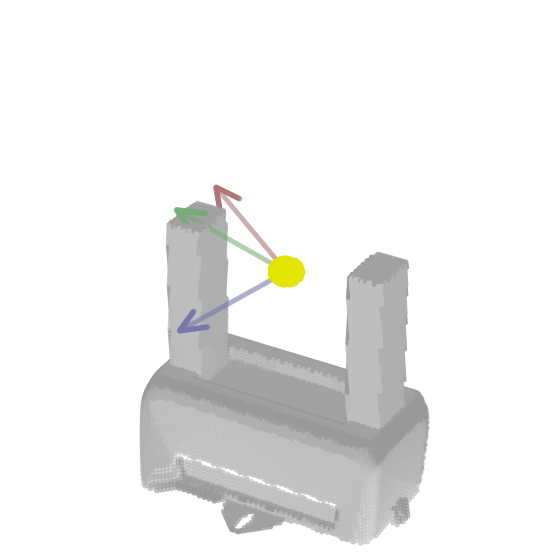

In [28]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.axis('off')

scatter_plot_ax(ax, poses, colors, (np.array([-5, 5]), np.array([-5, 5]), np.array([-5, 5])), frame_infos = [])

In [30]:
fig.savefig('gripper.png', transparent=True)

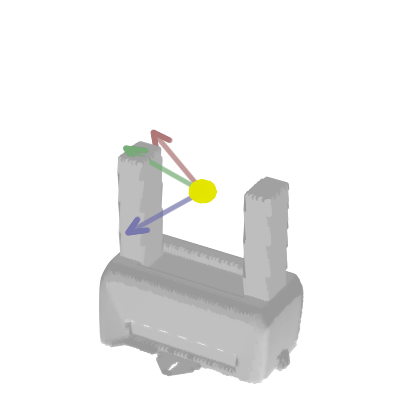

In [33]:
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111, projection='3d')
ax.axis('off')

scatter_plot_ax(ax, poses, colors, (np.array([-5, 5]), np.array([-5, 5]), np.array([-5, 5])), frame_infos = [])

In [34]:
fig.savefig('gripper_small.png', transparent=True)

In [ ]:
safd

In [ ]:
t1 = time.time()
##### Get Query Feature
optimizer_Q.zero_grad()
with torch.no_grad():
    outputs_Q = se3T_Q(inputs_Q)
    outputs_Q = tensor_field_Q({'feature':outputs_Q['feature'], 'pos':outputs_Q['pos'], 'query_pos':query_pos_Q.unsqueeze(0)})
assert outputs_Q['n_neighbor'].item() > 0
query_feature_Q = outputs_Q['field'].squeeze(0)

inputs_K = {'feature': feature_K, 'pos': pos_K, 'edge': None, 'max_neighbor_radius': max_radius_K}

##### MCMC
N_transforms = 100
mcmc_iter = 500
mcmc_iter = int(mcmc_iter)
langevin_iter = 100

optimizer_K.zero_grad()
optimizer_energy_K.zero_grad()
outputs_K = se3T_K(inputs_K)
outputs_K['query_feature'] = query_feature_Q
log_P_K = lambda T: -energy_model_K(outputs_K, T, temperature = temperature, learning = False)

T_seed = torch.cat([transforms.random_quaternions(N_transforms, device=device), torch.tensor([[2.5, 2.5, 0.5]], device = device)* torch.randn(N_transforms,3, device = device) + torch.tensor([0.,0., -29.], device = device)] , dim=-1)
t_mcmc_begin = time.time()
samples = metropolis_K.forward(log_P_K, max_iter = mcmc_iter, T_seed = T_seed, pbar=True)
Ts_K = samples['Ts']
As_K = samples['As']
samples = langevin_K.forward(log_P_K, max_iter = langevin_iter, optim = optimizer_energy_K, T_seed = Ts_K[-1], pbar=True)
Ts_K = torch.cat([Ts_K, samples['Ts']], dim=0)
As_K = torch.cat([As_K, samples['As']], dim=0)
t_mcmc_end = time.time()

Ts_K = Ts_K[-50:].reshape(-1,7)

##### Calculate energy and learn
optimizer_energy_K.zero_grad()
with torch.no_grad():
    E_K = energy_model_K(outputs_K, Ts_K, temperature = temperature, learning = True)

best_T_sp_idx = E_K.detach().argmin().item()
best_T_sp = Ts_K[best_T_sp_idx]
best_R_sp, best_X_sp = transforms.quaternion_to_matrix(best_T_sp[...,:4]), best_T_sp[...,4:]

##### Visualize
t2 = time.time()
print(f"Place inference time: {t2-t1}")
place_times.append(t2-t1)
if True:
    #print(f"=========Iter {0}=========")
    query_attn_K = (torch.softmax(energy_model_K.query_attention.detach(), dim=-1) ** 0.5).unsqueeze(-1).cpu().numpy()
    
    coord_query_K = energy_model_K.transform_query_points(best_T_sp).detach().cpu().numpy()
    color_query_K = torch.tensor([0.,0.,1.]).repeat(len(coord_query_K),1).cpu().numpy()
    color_query_K = np.concatenate([color_query_K, query_attn_K], axis=-1)
    frame_info_best = {'frame': best_R_sp.cpu().numpy(),
                    'origin': best_X_sp.cpu().numpy(), 
                    'alpha': 1.,
                    'pointcloud': (coord_query_K, color_query_K)
                    }

    world_origin_K = np.array([0., 0., -16.])
    frame_info_world = {'frame': np.eye(3),
                    'origin': world_origin_K,
                    'alpha': 0.,
                    'pointcloud': (Ts_K.detach().cpu().numpy()[:,4:], torch.tensor([0.,0.8,0.8,0.03]).repeat(len(Ts_K),1).numpy())
                    }

    color_unprocessed_alpha_K = np.concatenate([color_unprocessed_K, np.ones((len(color_unprocessed_K),1), dtype=int)], axis=-1)
    #scatter_plot(coord_K[in_range_cropped_idx_K], color_unprocessed_alpha_K[in_range_cropped_idx_K], xlim_K, ylim_K, zlim_K, frame_infos = [frame_info_best, frame_info_world], figsize = (8, 8))
    scatter_plot_ax(axes[1], coord_K[in_range_cropped_idx_K], color_unprocessed_alpha_K[in_range_cropped_idx_K], (xlim_K, ylim_K, zlim_K), frame_infos = [frame_info_best, frame_info_world])
    #print(E_K.detach()[::5])
    #print(f"Energy min: {E_K.min().item()} || Energy mean: {E_K.mean().item()}")
    #print(f"MCMC Time: {t_mcmc_end - t_mcmc_begin}")
    #print("===============================")





X_sdg, R_sdg = data_transform_K.inv_transform_T(best_X_sp.detach().cpu().numpy(), best_R_sp.detach().cpu().numpy())

#X_sdg = X_sdg + (R_sdg@ np.array([0., 0., 0.005])) # push the gripper forward a liitle

R_dg_dgpre = np.eye(3)
R_s_dgpre = R_sdg @ R_dg_dgpre
X_dg_dgpre = np.array([0., 0., -0.1])
sX_dg_dgpre = R_sdg @ X_dg_dgpre
X_s_dgpre = X_sdg + sX_dg_dgpre

pre_place = (X_s_dgpre, R_s_dgpre)
place = (X_sdg, R_sdg)

try:
    task.place(pre_place, place, sleep = sleep, IK_time = 1.)
except StopIteration:
    try:
        task.place(pre_place, place, sleep = sleep, IK_time = 5.)
    except StopIteration:
        print("place IK fail")
        N_IKFAIL_place += 1



if task.check_place_success():
    N_success_place += 1
    print('Place Success')
    print(f"Pick Success Rate: {int(100 * N_success_pick / N_tests)}%  ({N_success_pick} / {N_tests})    ||   Place Success Rate: {int(100 * N_success_place / max(N_success_pick, 1))}%   ({N_success_place} / {N_success_pick})    ||   Place-and-Place Success Rate: {int(100 * N_success_place / N_tests)}%   ({N_success_place} / {N_tests})")
else:
    print('Place Fail')
    print(f"Pick Success Rate: {int(100 * N_success_pick / N_tests)}%  ({N_success_pick} / {N_tests})    ||   Place Success Rate: {int(100 * N_success_place / max(N_success_pick, 1))}%   ({N_success_place} / {N_success_pick})    ||   Place-and-Place Success Rate: {int(100 * N_success_place / N_tests)}%   ({N_success_place} / {N_tests})")



pc = task.observe_pointcloud(stride = (1, 1))
scatter_plot_ax(axes[2], pc['coord'], pc['color'], pc['ranges'])
images = task.observe()
for i in range(3):
    axes_img[i].imshow(images[i]['color'])


if save_plot:
    if os.path.exists(output_path + "inference/") is False:
        os.makedirs(output_path + "inference/")
    fig.savefig(output_path + "inference/" + f"{seed}.png")
    if os.path.exists(output_path + "result/") is False:
        os.makedirs(output_path + "result/")
    fig_img.savefig(output_path + "result/" + f"{seed}.png")
if visualize_plot:
    plt.show()
else:
    plt.close(fig)
    plt.close(fig_img)
print("======================================")